# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn
import sklearn

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
sss.get_n_splits(train_images, train_labels)
(train_indices, validation_indices) = next(sss.split(train_images, train_labels))
(validation_images, validation_labels) = (train_images[validation_indices], train_labels[validation_indices])
(train_images, train_labels) = (train_images[train_indices], train_labels[train_indices])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [3]:
train_images_expanded = np.expand_dims(train_images, axis = 3)
validation_images_expanded = np.expand_dims(validation_images, axis = 3)
test_images_expanded = np.expand_dims(test_images, axis = 3)
with tf.device('CPU:0'):
    train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
    validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [5]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks, initial_epoch = 0):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    with tf.device('GPU:0'):
        history = model_name.fit(
        ti, tl,
        epochs = epochs,
        initial_epoch = initial_epoch,
        validation_data = (vi, vl))
        model_name.summary()
    return history
def write_to_json(dictionary, gmean, fscore, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    dictionary['fscore'] = str(fscore)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [6]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 57000 samples, validate on 3000 samples
Epoch 1/20
57000/57000 [==============================] - 8s 146us/sample - loss: 0.3762 - acc: 0.8947 - val_loss: 0.1507 - val_acc: 0.9560
Epoch 2/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.1048 - acc: 0.9681 - val_loss: 0.0854 - val_acc: 0.9753
Epoch 3/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.0730 - acc: 0.9783 - val_loss: 0.0849 - val_acc: 0.9740
Epoch 4/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.0575 - acc: 0.9825 - val_loss: 0.0581 - val_acc: 0.9840
Epoch 5/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.0477 - acc: 0.9852 - val_loss: 0.0574 - val_acc: 0.9820
Epoch 6/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.0396 - acc: 0.9880 - val_loss: 0.0474 - val_acc: 0.9860
Epoch 7/20
57000/57000 [==============================] - 7s 116us/sample - loss: 0.0345 - acc: 0.9891 - val_lo

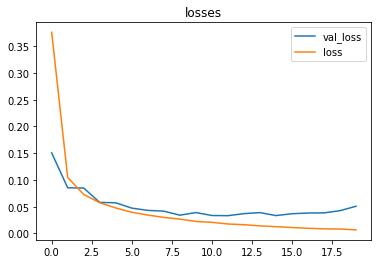

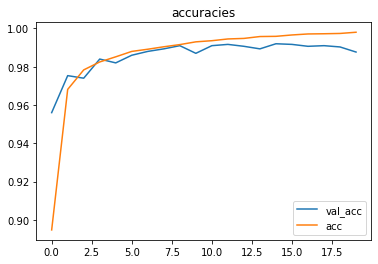

In [7]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [8]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.9896411178287615 
fscore: 0.989666203024648


In [9]:
write_to_json(history.history, baseline_gmean, baseline_fscore, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.1 \rho=1000$

{0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5, 6: 5150, 7: 5150, 8: 5150, 9: 5150}


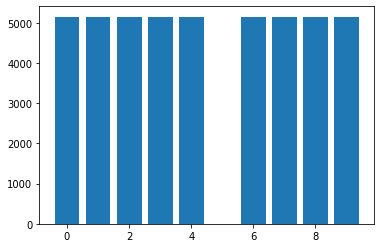

mu = 0.1, rho = 1030.0


In [6]:
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, 
                                                                              train_labels, np.float32(0.1), 1000)
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
    sss.get_n_splits(imb_train_images, imb_train_labels)
    (imb_train_indices, imb_validation_indices) = next(sss.split(imb_train_images, imb_train_labels))
    (imb_validation_images, imb_validation_labels) = (imb_train_images[imb_validation_indices], imb_train_labels[imb_validation_indices])
    (imb_train_images, imb_train_labels) = (imb_train_images[imb_train_indices], imb_train_labels[imb_train_indices])
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, train_labels, np.float32(0.1), 1000)
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_validation_images_expanded = np.expand_dims(imb_validation_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0
    imb_validation_images_tf = tf.cast(imb_validation_images_expanded, dtype = tf.float32) / 255.0

## check model behavior on untouched imbalanced set

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [12]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 46355 samples, validate on 2318 samples
Epoch 1/20
46355/46355 [==============================] - 6s 134us/sample - loss: 0.3892 - acc: 0.8864 - val_loss: 2.1961 - val_acc: 0.8438
Epoch 2/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.1138 - acc: 0.9667 - val_loss: 1.9380 - val_acc: 0.8680
Epoch 3/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.0748 - acc: 0.9781 - val_loss: 1.9071 - val_acc: 0.8619
Epoch 4/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.0599 - acc: 0.9817 - val_loss: 1.4215 - val_acc: 0.8758
Epoch 5/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.0503 - acc: 0.9849 - val_loss: 1.1104 - val_acc: 0.8775
Epoch 6/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.0429 - acc: 0.9868 - val_loss: 0.8711 - val_acc: 0.8796
Epoch 7/20
46355/46355 [==============================] - 5s 117us/sample - loss: 0.0371 - acc: 0.9886 - val_lo

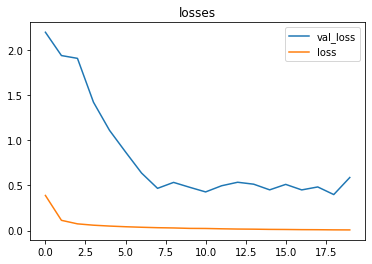

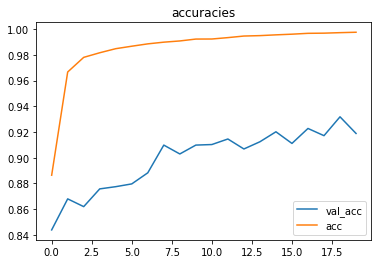

In [13]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [14]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds, average = 'macro')
    print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

gmean: 0.8730222366389603 
fscore: 0.9071398190369356


## train and evaluate model on randomly oversampled (ROS) data

In [9]:
print(f'before ros {hf.Imbalance.get_set_distribution(imb_train_labels)}')

(cp_img, cp_labels) = (imb_train_images, imb_train_labels)

imb_train_shape = imb_train_images.shape
#imb_validation_shape = imb_validation_images.shape
imb_train_images = imb_train_images.reshape(imb_train_shape[0], 
                                            imb_train_shape[1] * imb_train_shape[2])
#imb_validation_images = imb_validation_images.reshape(imb_validation_shape[0], 
#                                                      imb_validation_shape[1] * imb_validation_shape[2])



ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
(ros_train_images, ros_train_labels) = ros.fit_resample(imb_train_images, imb_train_labels)
#ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
#(ros_validation_images, ros_validation_labels) = ros.fit_resample(imb_validation_images, 
#                                                                  imb_validation_labels)



ros_train_images = ros_train_images.reshape(ros_train_images.shape[0], 
                                            imb_train_shape[1], 
                                            imb_train_shape[2])
#ros_validation_images = ros_validation_images.reshape(ros_validation_images.shape[0], 
#                                                      imb_validation_shape[1], 
#                                                      imb_validation_shape[2])
        
permutation = np.random.permutation(np.arange(ros_train_images.shape[0]))
print(permutation)
ros_train_images = ros_train_images[permutation]
ros_train_labels = ros_train_labels[permutation]

print(f'after ros {hf.Imbalance.get_set_distribution(ros_train_labels)}')



ros_train_images_expanded = np.expand_dims(ros_train_images, axis = 3)
#ros_validation_images_expanded = np.expand_dims(ros_validation_images, axis = 3)
with tf.device('CPU:0'):
    ros_train_images_tf = tf.cast(ros_train_images_expanded, dtype = tf.float32) / 255.0
    #ros_validation_images_tf = tf.cast(ros_validation_images_expanded, dtype = tf.float32) / 255.0

before ros {0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5, 6: 5150, 7: 5150, 8: 5150, 9: 5150}
[30040 43494 17300 ... 24933 29336 33971]
after ros {0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5150, 7: 5150, 8: 5150, 9: 5150}


In [20]:
print(np.max(ros_train_images_tf))

1.0


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [17]:
model_ros = tf.keras.models.Sequential()
history = model_run(model_ros, 20, ros_train_images_tf, ros_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
                    optimizer, loss, metrics, callbacks)

Train on 51500 samples, validate on 2318 samples
Epoch 1/20
51500/51500 [==============================] - 7s 127us/sample - loss: 0.3740 - acc: 0.8985 - val_loss: 0.2650 - val_acc: 0.9223
Epoch 2/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0980 - acc: 0.9705 - val_loss: 0.2542 - val_acc: 0.9340
Epoch 3/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0657 - acc: 0.9801 - val_loss: 0.2302 - val_acc: 0.9431
Epoch 4/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0507 - acc: 0.9849 - val_loss: 0.3199 - val_acc: 0.9379
Epoch 5/20
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0420 - acc: 0.9870 - val_loss: 0.2413 - val_acc: 0.9504
Epoch 6/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0346 - acc: 0.9896 - val_loss: 0.3379 - val_acc: 0.9327
Epoch 7/20
51500/51500 [==============================] - 6s 116us/sample - loss: 0.0302 - acc: 0.9908 - val_lo

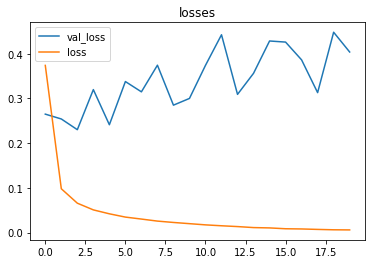

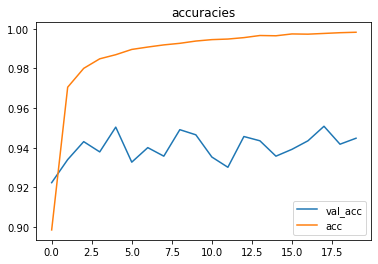

In [18]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [19]:
with tf.device('CPU:0'):
    model_ros_test_preds = tf.argmax(model_ros(test_images_tf), axis=-1)
    model_ros_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_ros_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_ros_fscore = sklearn.metrics.f1_score(test_labels, model_ros_test_preds, average = 'macro')
    print(f'gmean: {model_ros_gmean} \nfscore: {model_ros_fscore}')

gmean: 0.9395937475430605 
fscore: 0.9469965826360756


## train and evaluate model on adversarialy oversampled (AOS) data

create aos model identical to the baseline model on imbalanced data and train until arbitrary convergance

In [7]:
from importlib import reload
reload(hf)

<module 'Helper_functions' from '/home/wojciechowskiofficial/adversarial/Helper_functions.py'>

{0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5, 6: 5150, 7: 5150, 8: 5150, 9: 5150}


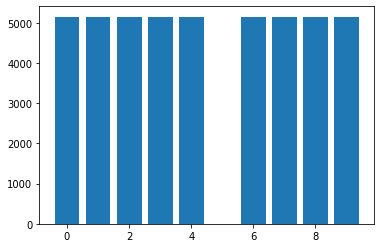

mu = 0.1, rho = 1030.0


In [10]:
(imb_train_images, imb_train_labels) = (cp_img, cp_labels)
print(hf.Imbalance.get_set_distribution(imb_train_labels))
hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [12]:
model_aos = tf.keras.models.Sequential()
history = model_run(model_aos, 1, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 46355 samples, validate on 2318 samples
46355/46355 [==============================] - 7s 156us/sample - loss: 0.3644 - acc: 0.8980 - val_loss: 1.5201 - val_acc: 0.8451
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 56)        14168     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 56)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 56)          28280     
_________________________________________________________________
flatten (F

In [22]:
(imb_train_images, imb_train_labels) = (cp_img, cp_labels)
distribution = hf.Imbalance.get_set_distribution(imb_train_labels)
aos_train_images, aos_train_labels = hf.Adversarial.oversample(imb_train_images_expanded, imb_train_labels,
                                                   tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                                                   model_aos, [0], 
                                                   data_type = 'step')


{0: 5150, 1: 5150, 2: 5150, 3: 5150, 4: 5150, 5: 5150, 6: 5150, 7: 5150, 8: 5150, 9: 5150}
sorted


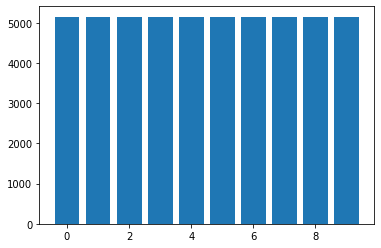

real


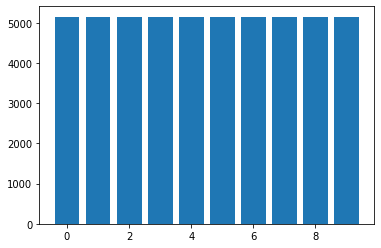

rho = 1.0


In [23]:
print(hf.Imbalance.get_set_distribution(aos_train_labels))
hf.Imbalance.plot_set_distribution(aos_train_images, aos_train_labels)

In [24]:
print(np.max(aos_train_images))

255.0


In [25]:
with tf.device('CPU:0'):
    aos_train_images = np.true_divide(aos_train_images, 255.0)
    aos_train_images_tf = tf.cast(aos_train_images, dtype = tf.float32)
print(np.max(aos_train_images_tf))

1.0


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

model_aos = tf.keras.models.Sequential()
history = model_run(model_aos, 3, aos_train_images_tf, aos_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 51500 samples, validate on 2318 samples
Epoch 1/3
51500/51500 [==============================] - 7s 131us/sample - loss: 0.3615 - acc: 0.8982 - val_loss: 1.2570 - val_acc: 0.8412
Epoch 2/3
51500/51500 [==============================] - 6s 117us/sample - loss: 0.1046 - acc: 0.9689 - val_loss: 1.1982 - val_acc: 0.8676
Epoch 3/3
51500/51500 [==============================] - 6s 117us/sample - loss: 0.0676 - acc: 0.9797 - val_loss: 1.1097 - val_acc: 0.8680
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 56)        14168     
__________________________________________________

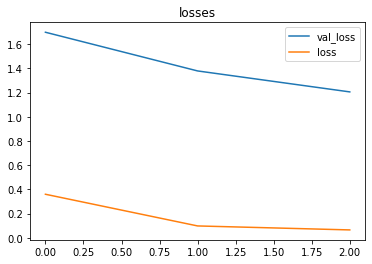

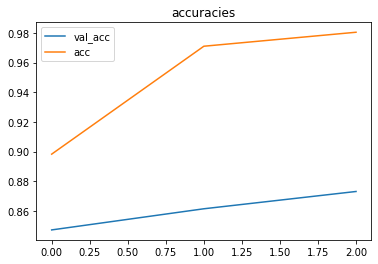

In [156]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [157]:
with tf.device('CPU:0'):
    model_aos_test_preds = tf.argmax(model_aos(test_images_tf), axis=-1)
    model_aos_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_aos_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_aos_fscore = sklearn.metrics.f1_score(test_labels, model_aos_test_preds, average = 'macro')
    print(f'gmean: {model_aos_gmean} \nfscore: {model_aos_fscore}')

gmean: 0.19986669929212728 
fscore: 0.8443584909648933


3


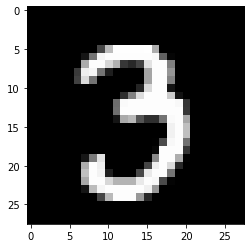

6


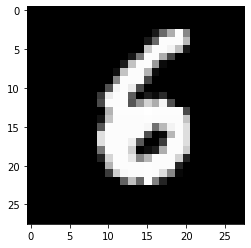

9


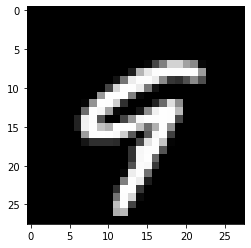

7


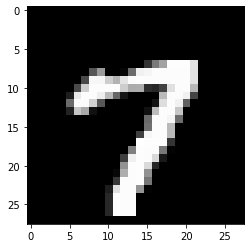

9


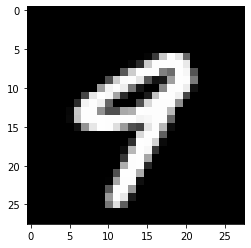

7


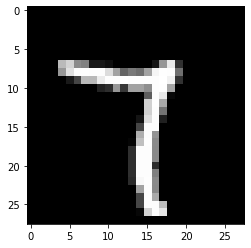

4


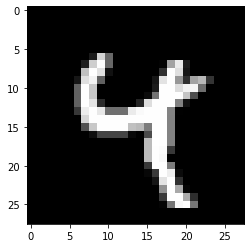

3


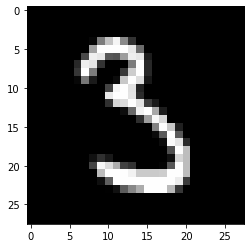

8


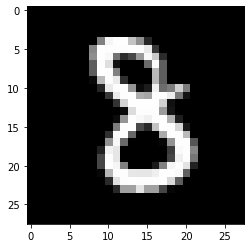

3


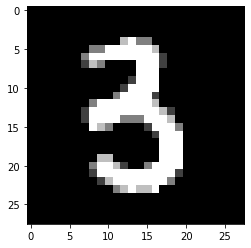

5


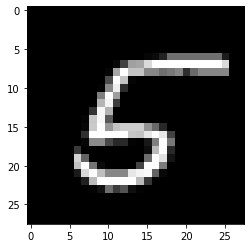

9


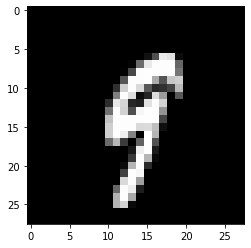

8


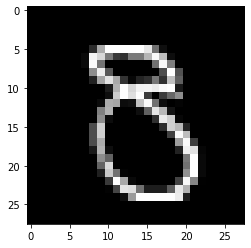

7


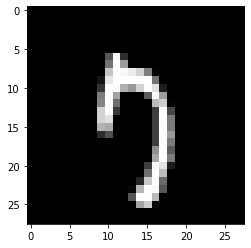

0


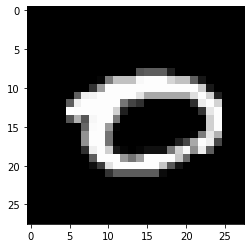

1


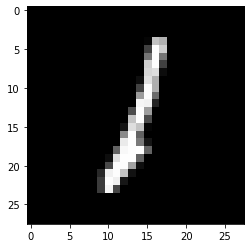

2


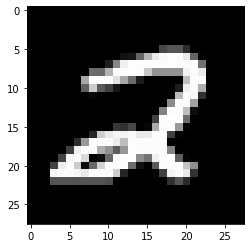

1


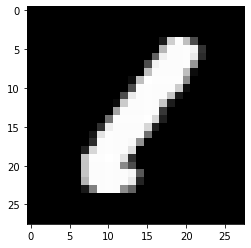

8


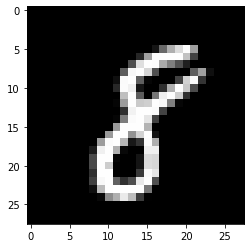

8


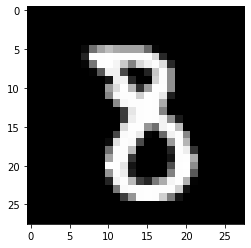

5


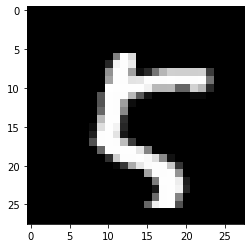

7


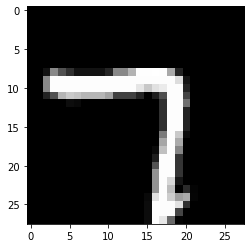

6


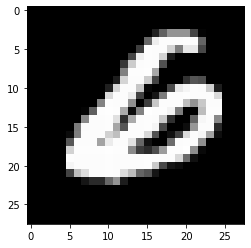

9


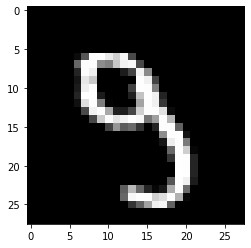

2


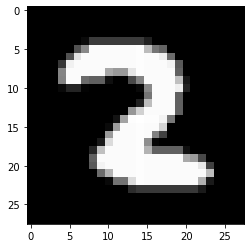

2


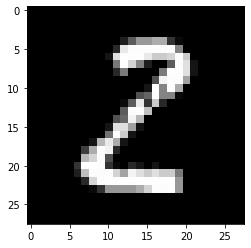

5


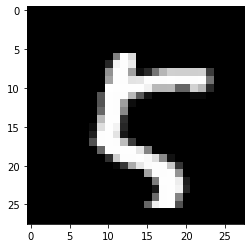

3


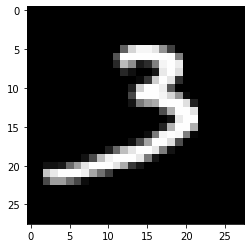

4


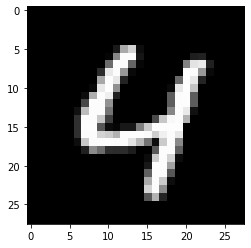

0


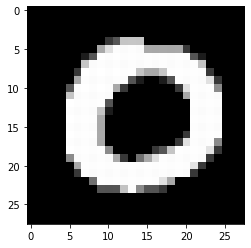

8


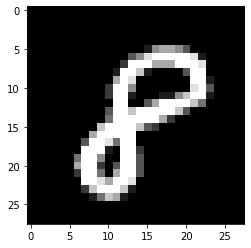

4


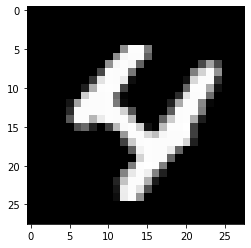

7


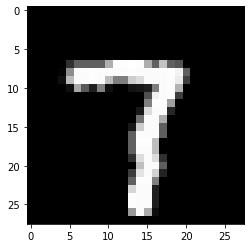

3


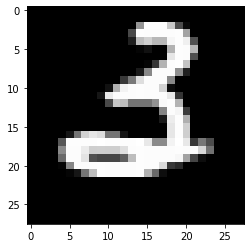

0


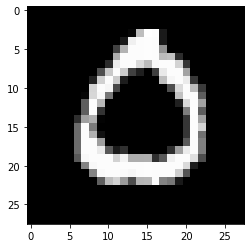

6


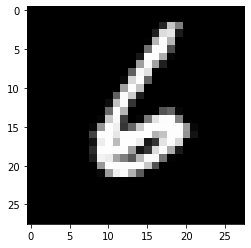

0


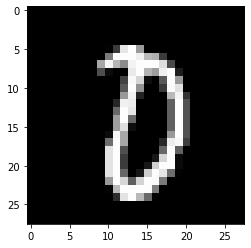

1


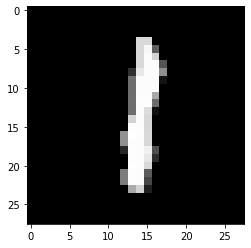

7


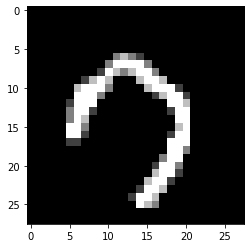

0


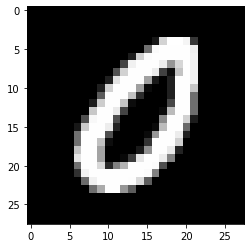

8


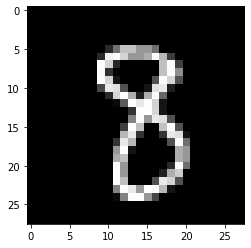

8


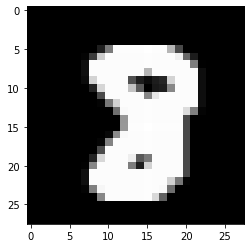

5


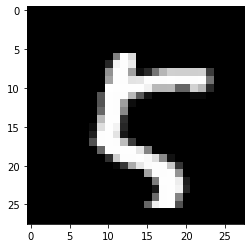

0


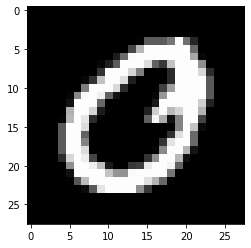

4


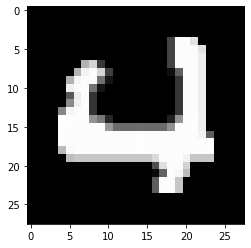

9


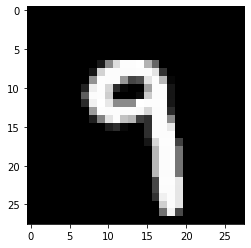

1


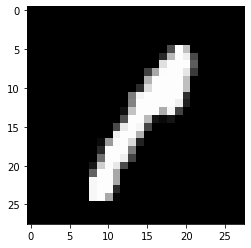

2


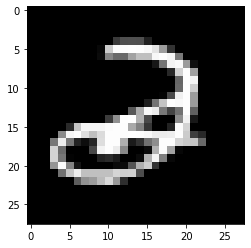

5


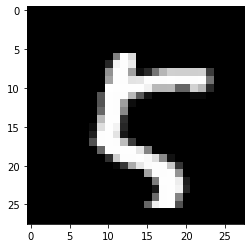

6


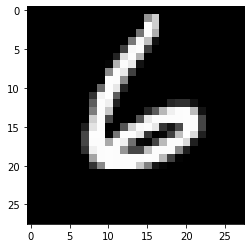

1


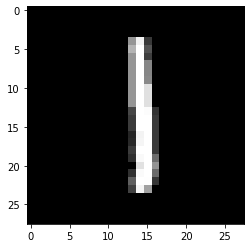

3


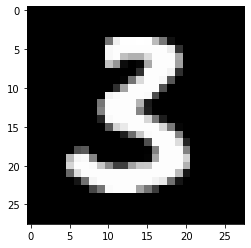

3


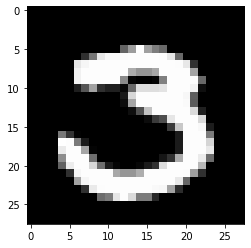

0


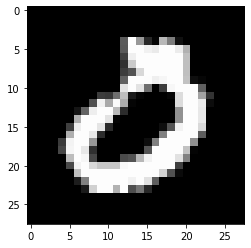

4


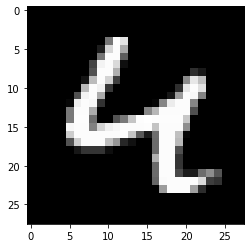

9


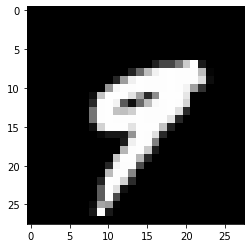

8


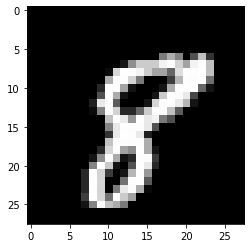

5


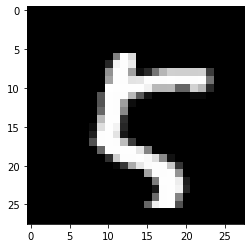

6


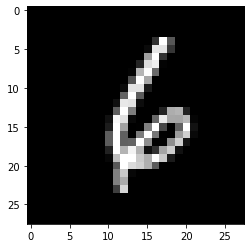

5


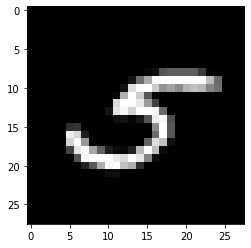

4


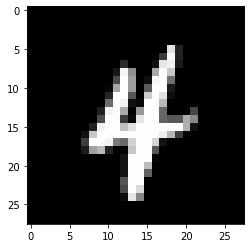

4


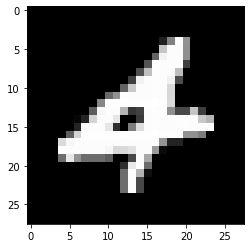

3


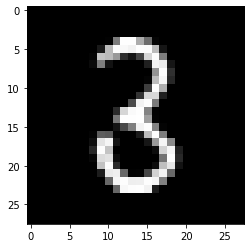

7


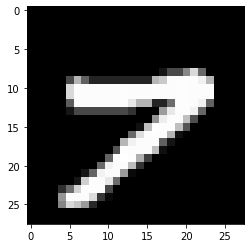

7


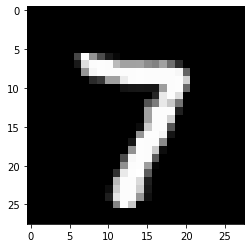

8


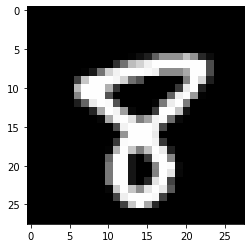

1


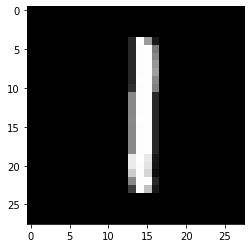

3


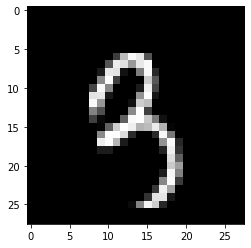

0


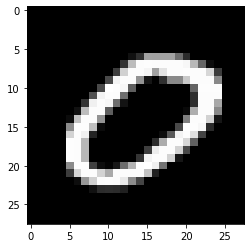

2


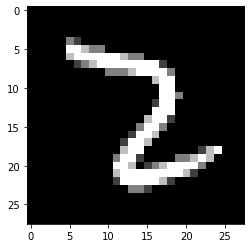

6


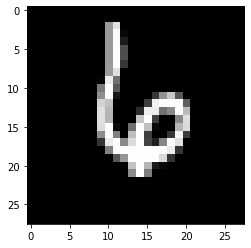

9


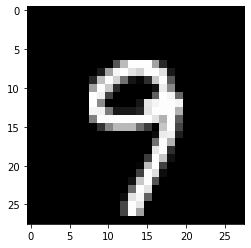

9


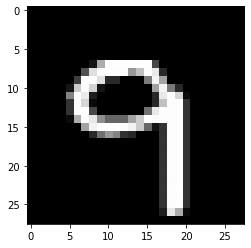

8


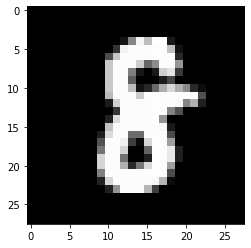

2


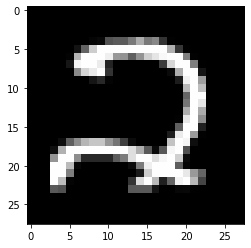

5


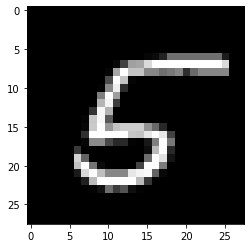

5


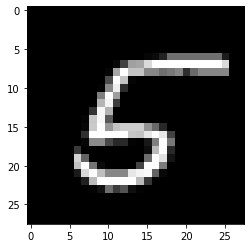

7


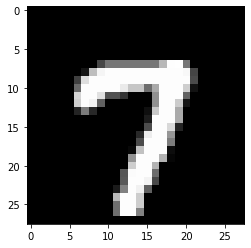

6


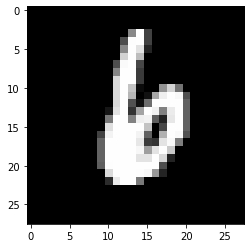

9


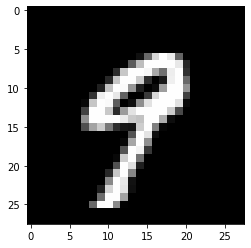

1


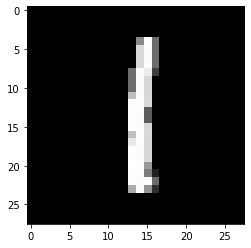

4


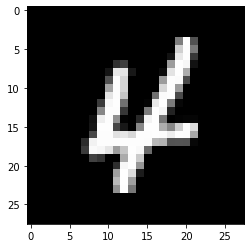

7


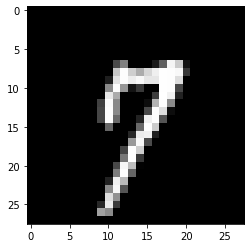

0


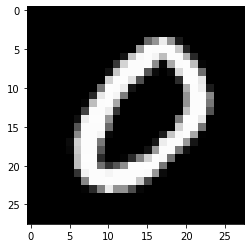

0


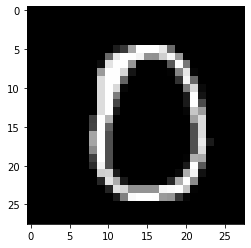

4


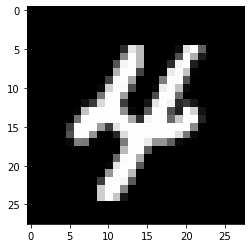

8


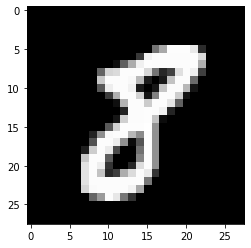

4


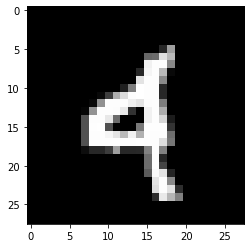

0


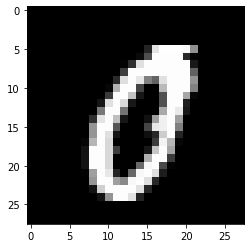

3


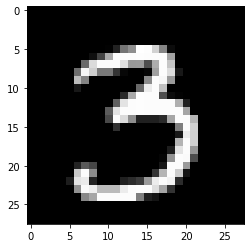

3


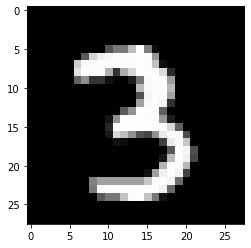

4


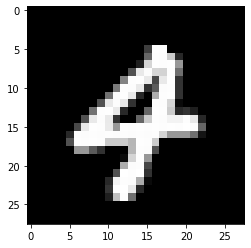

4


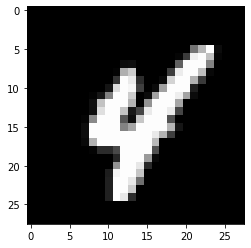

2


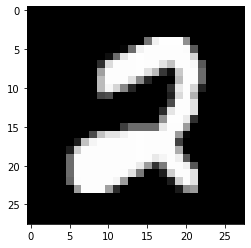

8


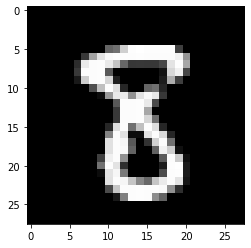

1


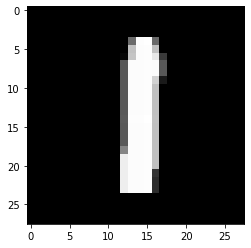

0


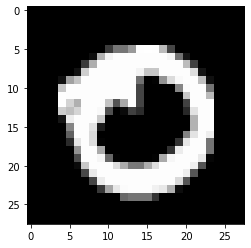

9


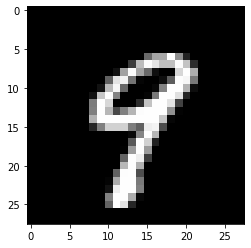

2


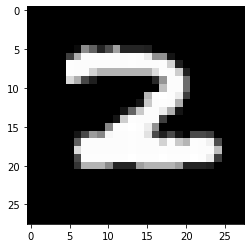

3


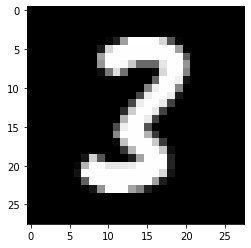

In [19]:
for i in range(100):
    print(aos_train_labels[i])
    plt.imshow(tf.squeeze(aos_train_images_tf[i]), cmap = 'gray')
    plt.show()